# Time-series analysis of SRlite and TOA VHR imagery

#### Examine SRlite & TOA stability across overlapping strips 
#### Create a time series of values at selected sites within a bounding box  
#### `NOTE`: these data are cloudmasked, but not screened for the quality of this masking - still contamination which will interfere with time-series trends outside of deserts 

Paul Montesano  
2023

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show

from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt

from shapely.geometry import Point
import glob
import numpy as np
import shapely
from shapely.geometry import Point, Polygon
from datetime import datetime
import os
import pyproj
import random

# !pip install mizani
#!pip install plotnine
import plotnine
from plotnine import * 
from mizani.breaks import date_breaks
from mizani.formatters import date_format

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib

import contextily as ctx
from contextily.tile import warp_img_transform, warp_tiles, _warper

In [2]:
def do_scalebar(ax):
    return ax.add_artist(ScaleBar(
        dx=1,
        units="km",
        dimension="si-length",
         length_fraction=0.25,
        scale_formatter=lambda value, unit: f' {value} km ',
        location='lower left'
        ))

Functions to generate random points

In [3]:
def Random_Points_in_Bounds(polygon, number):
    
    np.random.seed(42)
    
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y

def get_points_in_bounds(rio_dataset=None, GEOM=None, n_points=100, lon=None, lat=None):
    '''Return a gdf of a points within a bounds:
    Can be from a set of n random points within a rasterio dataset's bounds 
    Can be from a given lon, lat
    https://www.matecdev.com/posts/random-points-in-polygon.html
    '''
    
    if rio_dataset is not None:


        # Create shapely polygon from raster bounds
        from shapely.geometry import box
        GEOM = box(*rio_dataset.bounds)
        INDEX = rio_dataset.name
        CRS=rio_dataset.crs
        NAME = os.path.basename(rio_dataset.name)

        if lon is None and lat is None:
            # You want random points
            x,y = Random_Points_in_Bounds(GEOM, n_points)

            # Convert to lon,lat
            inProj = pyproj.Proj(rio_dataset.crs)
            outProj = pyproj.Proj(init='epsg:4326')
            lon, lat = pyproj.transform(inProj, outProj, x, y)
        else:
            # You have a single point (in lon,lat)
            # Convert to lon,lat
            outProj = pyproj.Proj(rio_dataset.crs)
            inProj = pyproj.Proj(init='epsg:4326')
            x, y = pyproj.transform(inProj, outProj, [lon], [lat])
    elif GEOM is not None:
        # Use the GEOM to get bounds, assume 4326
        # You want random points
        x,y = Random_Points_in_Bounds(GEOM, n_points)
        lon, lat = x, y
        INDEX=0
        CRS=4326
        NAME = 'box'
    else:
        print('Need a raster of a bbox')
        return None
    
    # 
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df["lon"] = lon
    df["lat"] = lat
    df['geometry'] = df['points'].apply(Point)
    df['site'] = df.index + 1
    df['crs'] = pyproj.Proj(CRS)

    gdf_points = gpd.GeoDataFrame(df, geometry='geometry', crs=CRS)
    #gdf_points.plot(ax=ax, color='red')
        
    gdf_poly = gpd.GeoDataFrame(index=[INDEX], geometry=[GEOM], crs=CRS)
    gdf_poly['name'] = NAME
    
    return gdf_points, gdf_poly

Function to extract the raster values for points in the gdf

In [4]:
def get_ref_timeseries_table(points_gdf, f_list, batchname=None, DO_4BAND=True, RM_LIST = ["BAND_C","BAND_Y","BAND_RE","BAND_N2"], NODATA_VAL = -9999, REF_SCALE_FACTOR = 10000.0, CHG_YR_COLNAME = None, CHG_NAME_COLNAME=None, DEBUG=False):
    
    '''Get a timeseries data frame of reflectance (SR, TOA) band values for a gdf of points for a list of rasters'''
    
    # A list of all the points (sites) with each SR value of each raster
    data_qb, data_wv, data_wv8band, data_ge = [], [], [], []
    bandnames_list_qb02, bandnames_list_wv, bandnames_list_wv8band, bandnames_list_ge = [],[],[],[]
    
    # Prepare points gdf disturbance column
    if CHG_YR_COLNAME is None:
        points_gdf['date_chg'] = None
        points_gdf['name_chg'] = None
        
    else:
        
        points_gdf['date_chg'] = points_gdf[CHG_YR_COLNAME]
        if CHG_NAME_COLNAME is None:
            points_gdf['name_chg'] = None
        else:
            points_gdf['name_chg'] = 'Disturbance\n' + points_gdf[CHG_NAME_COLNAME]
            
        #points_gdf.drop(columns=[CHG_YR_COLNAME], inplace=True)
        
    df_list = []
    
    # Loop over list of rasters from a glob of an SRlite output batch dir
    for i, fpath in enumerate(f_list):

        with rasterio.open(fpath) as src:
            # Discover the band names by file
            # Clean up band names in raster
            if DEBUG:
                print(src.descriptions)
            if list(src.descriptions)[0] is None:
                bandnames_list = [str(i+1) for i, b in enumerate(list(src.descriptions))]
            else:
                bandnames_list = [b.replace('-','_') for b in list(src.descriptions)]

            if DEBUG:
                print(bandnames_list)
                
            # Use the points_gdf to get site coords and name
            coord_list = [(x,y,site,lon,lat,date_chg,name_chg) for x,y,site,lon,lat,date_chg,name_chg in zip(points_gdf['geometry'].x , points_gdf['geometry'].y, points_gdf['site'], points_gdf['lon'], points_gdf['lat'], points_gdf['date_chg'], points_gdf['name_chg'])]
            
           #  Use site coords and name to sample raster and add to data
            for i,n in enumerate(coord_list):

                coord_list_site = [coord_list[i][0:2]]
                if DEBUG: print(coord_list_site)
                
                site_name = coord_list[i][2]
                lon = round(coord_list[i][3], 6)
                lat = round(coord_list[i][4], 6)
                date_chg = coord_list[i][5]
                name_chg = coord_list[i][6]
                
                if DEBUG: print(site_name)
                
                # Sample the reflectance values for each band at each point
                reflectance_list = [x/REF_SCALE_FACTOR for x in src.sample(coord_list_site)]
                list_reflectance_data_row = [item for sublist in reflectance_list for item in sublist]
                
                # If you have only 4 band data to begin with, set DO_4BAND
                #if len(list_reflectance_data_row) == 4:
                #    DO_4BAND = True
                #else:
                #    DO_4BAND = False
                    
                if DO_4BAND:
                    #all_BANDS_list = ['BAND_C', 'BAND_B', 'BAND_G', 'BAND_Y', 'BAND_R', 'BAND_RE', 'BAND_N', 'BAND_N2']
                    idx_4BAND = [bandnames_list.index(x) for x in bandnames_list if x not in RM_LIST]
                    # Get just the data that corresponds to the 4BAND data
                    list_reflectance_data_row = [list_reflectance_data_row[i] for i in idx_4BAND]
                #print(len(list_reflectance_data_row))
                    
                # Get image info: sensor, name, and date
                name = os.path.basename(fpath).split('-')[0]
                sensor = name.split('_')[0]
                datestring = name.split('_')[1]
                #print(datestring)
                
                # Append the current site's data to the correct sensor data list
                site_data = [site_name, date_chg, name_chg] + [lon] + [lat] + [coord_list_site] + [batchname] + [sensor] + [name] + [datestring] + list_reflectance_data_row
                    
                if 'QB02' in fpath:
                    data_qb.append(site_data)
                    bandnames_list_qb02 = bandnames_list
                    SENSOR_CLASS = 'QB'
                if 'WV0' in fpath:
                    if len(bandnames_list) == 8:
                        data_wv8band.append(site_data)
                        bandnames_list_wv8band = bandnames_list 
                        data_wv8band.append(site_data)
                    else:
                        data_wv.append(site_data)
                        bandnames_list_wv = bandnames_list
                        data_wv.append(site_data)
                    bandnames_list_wv = bandnames_list
                    SENSOR_CLASS = 'WV'
                if 'GE01' in fpath:
                    data_ge.append(site_data)
                    bandnames_list_ge = bandnames_list
                    SENSOR_CLASS = 'GE'
        if DEBUG: print(SENSOR_CLASS)
                # Append the current site's data
                #data.append([site_name] + \
                #                [lon] + [lat] + 
                #                [coord_list_site] + \
                #                #[inProj] + 
                #                [batchname] + [sensor] + [name] + [datestring] + [item for sublist in reflectance_list for item in sublist])
                
    for i, data in enumerate([data_qb, data_wv, data_wv8band, data_ge]):
        if len(data) > 0:
            if DEBUG: print(data)
            bandnames_list = [bandnames_list_qb02, bandnames_list_wv, bandnames_list_wv8band, bandnames_list_ge][i] 
            
            if DO_4BAND:
                # Just drop the extra WV02 band names for now..
                bandnames_list = [b for b in bandnames_list if b not in RM_LIST]
            #print(bandnames_list)
            if DEBUG: print(pd.DataFrame(data).info())
            
            df = pd.DataFrame(data, columns = ['site','date_chg','name_chg'] + ['lon', 'lat'] + ['geometry'] + ['batchname','sensor','name', 'date'] + bandnames_list).replace(NODATA_VAL/REF_SCALE_FACTOR, np.nan)
            df['date_chg'] = pd.to_datetime(df['date_chg'], format="%Y%m%d")
            df['date'] = pd.to_datetime(df['date'], format="%Y%m%d")
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            if DEBUG: print(df)
            df_list.append(df)
     
    return pd.concat(df_list, axis=0, ignore_index=True)
    

Make a list of rasters for the time-series

In [5]:
MAIN_DIR = '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all'
OUTDIR = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss'

DICT_BATCH_WHITESANDS = {
    #'f_sr_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.13-08012022-GLAD-ARD/09192022/Whitesands/*sr-02m.tif'),
    'f_sr_list': glob.glob(f'{MAIN_DIR}/Whitesands/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Whitesands/*M1BS*toa.tif'),
    'f_ccdc_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/ccdc/ccdc_v20220620/*ccdc.tif'),
    'batchname': 'White Sands',
    'target_catid': '1010010009F6C100',
    'target_geom' : shapely.geometry.box(-106.35, 32.9, -106.25, 32.95), #gpd.GeoDataFrame(index=[0], geometry=[shapely.geometry.box(-106.35, 32.9, -106.25, 32.95)], crs=4326).to_crs(32613).geometry[0],
    'utm_epsg': 32613, 
    'lon': -106.35, 
    'lat': 32.92,
    'cx_bounds': [-108,-105,30,35],
    'band_rename_dict': {'BAND_B': 'BAND_B', 'BAND_G': 'BAND_G', 'BAND_R': 'BAND_R', 'BAND_N': 'BAND_N'}
}
DICT_BATCH_RRValley = {
    'f_sr_list': glob.glob(f'{MAIN_DIR}/RailroadValley/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/RailroadValley/*M1BS*toa.tif'),
    'f_ccdc_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/ccdc/**/*ccdc.tif'),
    'batchname': 'Railroad Valley',
    'target_catid': '10300100887E1A00',#'104001001EBCCC00'
    'target_geom' : None,
    'lon': 100, 
    'lat': 70,
    'cx_bounds': [-115.98,-115.5,38.25,38.73],
    'band_rename_dict': {'BAND_B': 'BAND_B', 'BAND_G': 'BAND_G', 'BAND_R': 'BAND_R', 'BAND_N': 'BAND_N'}
}
DICT_BATCH_ALASKA = {
    #'f_sr_list': glob.glob(f'{MAIN_DIR}/Alaska/*sr-02m.tif'),
    'f_sr_list': glob.glob('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/002m/*sr-02m.tif', recursive=True),
    #'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Alaska/*M1BS*toa.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/toa/002m/*toa.tif', recursive=True),
    'f_ccdc_list': glob.glob('/explore/nobackup/projects/above/misc/ABoVE_Shrubs/ccdc/030m/*ccdc.tif'),
    'batchname': 'Alaska',
     #'target_catid': '1040010050B3FC00',
    #'target_catid': '10400100501FDA00', # bad - lots of fire area, short time series
    #'target_catid': '1030010081D38000', # good - some fire, decadal time span
    #'target_catid': '103001007E6B8D00', #
    #'target_catid': '104001003D861300', # Not found now?
    'target_catid': '10300100045FA300',
    'target_geom' : None,
    #'target_geom': shapely.geometry.box(-145, 63.75, -144.9, 63.82),
    'lon': -149.0187, 
    'lat': 65.0246,
    'cx_bounds': [-175,-125,40,90],
    'band_rename_dict': {'BAND_B': 'BAND_B', 'BAND_G': 'BAND_G', 'BAND_R': 'BAND_R', 'BAND_N': 'BAND_N'}
}
DICT_BATCH_SENEGALETZ = {
    'f_sr_list': glob.glob(f'{MAIN_DIR}/Senegal/*sr-02m.tif'), #/explore/nobackup/projects/3sl/data/SRLite
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Senegal/*M1BS*toa.tif'),  #/explore/nobackup/projects/3sl/data/VHR/*/M1BS
    'f_ccdc_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/ccdc/**/*ccdc.tif'), #/explore/nobackup/people/mmacande/srlite/srlite_shared/ccdc_20230309_senegal_ccdc/Senegal_CAS
    'batchname': 'SenegalETZ',
    'target_catid': '10300100276F1900', 
    'target_geom' : None,
    'lon': None, 
    'lat': None,
    'cx_bounds': [-15.3,  13, -13.5,  15.6],
    'band_rename_dict': {'BAND_B': 'BAND_B', 'BAND_G': 'BAND_G', 'BAND_R': 'BAND_R', 'BAND_N': 'BAND_N'}
}
DICT_BATCH_SENEGAL3SL = {
    'f_sr_list': glob.glob(f'/explore/nobackup/projects/3sl/data/SRLite/*/*sr-02m.tif'), #
    'f_toa_list': glob.glob('/explore/nobackup/projects/3sl/data/VHR/*/M1BS/*toa.tif'),  #
    'f_ccdc_list': glob.glob('/explore/nobackup/people/mmacande/srlite/srlite_shared/ccdc_20230309_senegal_ccdc/Senegal_*/*ccdc.tif'), #
    'batchname': 'Senegal3SL',
    #'target_catid': '1030010007C73D00', 
    'target_catid': 'FCF00', 
    'target_geom' : None,
    'lon': None, 
    'lat': None,
    'cx_bounds': [-15.3,  13, -13.5,  15.6],
    'band_rename_dict': {'2': 'BAND_B', '3': 'BAND_G', '5': 'BAND_R', '7': 'BAND_N'}
}
DICT_BATCH_SIBERIA = {
    'f_sr_list': glob.glob(f'{MAIN_DIR}/Siberia/*sr-02m.tif'),
    'f_toa_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/toa/Siberia/*M1BS*toa.tif'),
    'f_ccdc_list': glob.glob('/explore/nobackup/projects/ilab/data/srlite/ccdc/**/*ccdc.tif'),
    'batchname': 'Siberia',
    #'target_catid': '10300100223FD400', # bad
    #'target_catid': '104001001EBCCC00', # no time series
    #'target_catid': '10300100598FE300', # no time series - 2 on same day
    'target_catid': '1030010046C0A100',#'1030010059D29400',
    'target_geom' : shapely.geometry.box(105.55,70.62,106,70.71), # All NAN values at points...
    'target_geom' : shapely.geometry.box(102.75, 70.75, 103.25, 70.9),
        'lon': 100, 
    'lat': 70,
    'cx_bounds': [90,110,60,75],
    'band_rename_dict': {'BAND_B': 'BAND_B', 'BAND_G': 'BAND_G', 'BAND_R': 'BAND_R', 'BAND_N': 'BAND_N'}
}

In [6]:
SELECTED_DICT = DICT_BATCH_WHITESANDS #DICT_BATCH_RRValley #DICT_BATCH_SENEGAL3SL #DICT_BATCH_WHITESANDS #DICT_BATCH_ALASKA

XMIN, XMAX, YMIN, YMAX = SELECTED_DICT['cx_bounds']

BATCHNAME = SELECTED_DICT['batchname']

nowtime = pd.Timestamp.now().strftime('%Y%m%d')

# Update a string describing the types of observations being considered as you move through the analysis
OBS_DESCR = ''

print(f"{SELECTED_DICT['batchname']} has:\n", len(SELECTED_DICT['f_sr_list']), 'srlite\n', len(SELECTED_DICT['f_toa_list']), 'toa\n', len(SELECTED_DICT['f_ccdc_list']), 'ccdc')

White Sands has:
 14 srlite
 15 toa
 502 ccdc


In [7]:
BAND_RENAME_DICT_forPLOT = {'BAND_B': 'blue', 'BAND_G': 'green', 'BAND_R': 'red', 'BAND_N': 'nir'}
BAND_RENAME_DICT = SELECTED_DICT['band_rename_dict']
TOA_str = "$TOA_{VHR}$"
SR_str = "$SR_{VHR}$"
SR_ref_str = "$SR_{reference}$"

## Get corresponding list of reflectance data
VHR SR, VHR TOA, CCDC SR

In [8]:
%%time
f_sr_list_match = []
f_toa_list_match = []
f_ccdc_list_match = []
f_toa_stripname_list = []

for r_fn in SELECTED_DICT['f_sr_list']:
    stripname = os.path.basename(r_fn).split('-sr')[0]
    
    for i, toa_fn in enumerate(SELECTED_DICT['f_toa_list']):
        toa_stripname = os.path.basename(toa_fn).split('-toa')[0]
        
        if toa_stripname == stripname and toa_stripname not in f_toa_stripname_list:
            # Get corresponding CCDC
            ccdc_fn = [ccdc_fn for ccdc_fn in SELECTED_DICT['f_ccdc_list'] if os.path.basename(ccdc_fn).split('-ccdc')[0] == stripname][0]
            
            f_ccdc_list_match.append(ccdc_fn)
            f_sr_list_match.append(r_fn)
            f_toa_stripname_list.append(toa_stripname)
            f_toa_list_match.append(SELECTED_DICT['f_toa_list'][i])
            
            #print(os.path.basename(r_fn))
            #print(os.path.basename(toa_fn))



CPU times: user 4.18 ms, sys: 0 ns, total: 4.18 ms
Wall time: 4.18 ms


In [9]:
print(len(f_sr_list_match), 'srlite', len(f_toa_list_match), 'toa', len(f_ccdc_list_match), 'ccdc')

14 srlite 14 toa 14 ccdc


In [10]:
i=1
print(f_sr_list_match[i])
print(f_toa_list_match[i])
print(f_ccdc_list_match[i])

/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/QB02_20021020_M1BS_1010010001594B00-sr-02m.tif
/explore/nobackup/projects/ilab/data/srlite/toa/Whitesands/QB02_20021020_M1BS_1010010001594B00-toa.tif
/explore/nobackup/projects/ilab/data/srlite/ccdc/ccdc_v20220620/QB02_20021020_M1BS_1010010001594B00-ccdc.tif


### Reset the lists of SRlite and TOA

In [11]:
SELECTED_DICT['f_sr_list'] = f_sr_list_match
SELECTED_DICT['f_toa_list'] = f_toa_list_match
SELECTED_DICT['f_ccdc_list'] = f_ccdc_list_match

## Get all footprints of data in list

In [12]:
%%time 
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in SELECTED_DICT['f_sr_list']]
footprint_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=BATCHNAME, DROP_DUPLICATES=True)

Building GDF from list...
CPU times: user 205 ms, sys: 26.7 ms, total: 232 ms
Wall time: 512 ms


In [13]:
footprint_gdf = footprintlib.get_attributes_from_filename(footprint_gdf, image_type='SR', file_split_str='-sr-' )
footprint_gdf.total_bounds

array([-106.50812095,   32.75797882, -106.14617191,   33.08320348])

In [14]:
# Explore the footprints
#footprint_gdf[['file','geometry']].explore()

### Extent of the `target_geom` 
#### show a target extent in which random points will fall

In [15]:
print('Building target extent...')
if SELECTED_DICT['target_geom'] is not None:
    print('target geom...')
    site_kwargs = {'lon': SELECTED_DICT['target_geom'].centroid.x, 'lat': SELECTED_DICT['target_geom'].centroid.y }
    target_extent_gdf = gpd.GeoDataFrame(index=[0], geometry=[SELECTED_DICT['target_geom']], crs=4326)
    EXTENT_ID_STR = "_".join(format(x, "0.2f") for x in SELECTED_DICT['target_geom'].bounds)
else:
    EXTENT_ID_STR = SELECTED_DICT['target_catid']
    fn_list_of_selected_catid = [i for i in SELECTED_DICT['f_sr_list'] if SELECTED_DICT['target_catid'] in i]
    print(f'Path of the target catid: {fn_list_of_selected_catid}')
    target_extent_gdf = footprint_gdf[footprint_gdf['file'].str.contains(SELECTED_DICT['target_catid'])] 


Building target extent...
target geom...


## Set the Site ID
for identifying output files

In [16]:
SITE_ID_STRING = f"{BATCHNAME.replace(' ','')}_{EXTENT_ID_STR}_{nowtime}"
SITE_ID_STRING

'WhiteSands_-106.35_32.90_-106.25_32.95_20240821'

Plotting footprints in black, and target extent in red.


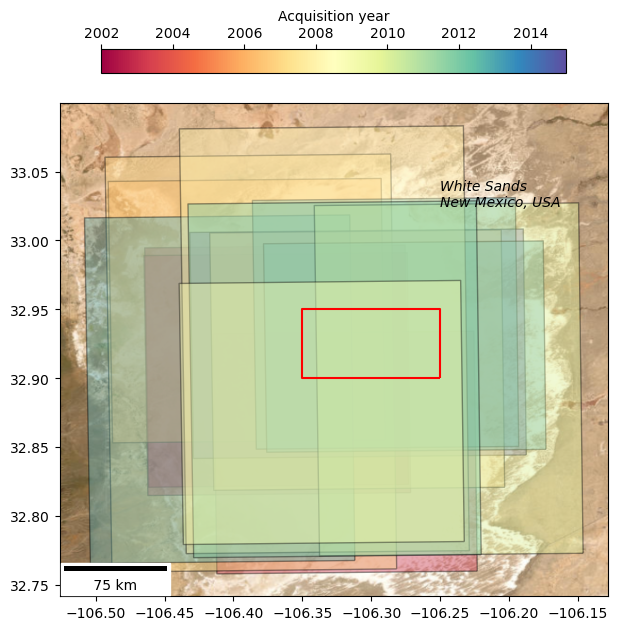

In [17]:
print('Plotting footprints in black, and target extent in red.')

# Scale bar would be nice but doesnt load
# https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html

footprint_gdf['year_cat'] = footprint_gdf['year'].astype('category')

ax = footprint_gdf.cx[XMIN:XMAX, YMIN:YMAX].plot(cmap='Spectral', ec='k', alpha=0.4, figsize=(12,8), column='year', legend=True, 
                                            #legend_kwds=dict(weight=1, fillColor='white', fillOpacity=0.25)
                                            legend_kwds={'label': "Acquisition year", "location":'top', 'shrink': 0.5,
                                             'orientation': "horizontal"}
                                           )
ax.annotate('White Sands\nNew Mexico, USA', [-106.25,33.025], style= "italic")
ax = target_extent_gdf.boundary.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs=4326, attribution=' ' ,
    #source = ctx.providers.Gaode.Satellite
    #source = ctx.providers.Esri.WorldShadedRelief
    #source = ctx.providers.Esri.WorldGrayCanvas
    #source = ctx.providers.Esri.NatGeoWorldMap
    source = ctx.providers.Esri.WorldImagery
    #source = ctx.providers.Esri.DeLorme
)
do_scalebar(ax)

In [18]:
footprint_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   file            14 non-null     object        
 1   geometry        14 non-null     geometry      
 2   footprint_name  14 non-null     object        
 3   path            14 non-null     object        
 4   area_km2        14 non-null     float64       
 5   area_ha         14 non-null     float64       
 6   type            14 non-null     object        
 7   catid           14 non-null     object        
 8   sensor          14 non-null     object        
 9   year            14 non-null     int64         
 10  month           14 non-null     int64         
 11  date            14 non-null     datetime64[ns]
 12  year_cat        14 non-null     category      
dtypes: category(1), datetime64[ns](1), float64(2), geometry(1), int64(2), object(6)
memory usage: 1.8+ KB


In [19]:
BASEMAP = 'World_Imagery' # 
footprint_gdf[['file','geometry','year']].cx[XMIN:XMAX, YMIN:YMAX].explore(column='year', cmap='Spectral', tiles=f'https://server.arcgisonline.com/arcgis/rest/services/{BASEMAP}/MapServer/tile/'+'{z}/{y}/{x}', attr=' ')

In [20]:
# import folium
# m=footprint_gdf.explore()
# m.add_child(folium.LatLngPopup())

In [21]:
# # Example selection of all footprints that match a string
# footprint_gdf[footprint_gdf.apply(lambda row: row.astype(str).str.contains('20180528').any(), axis=1)]

### Alaska Fires, post 2010

In [22]:
if BATCHNAME == 'Alaska':
    fires_fn = '/explore/nobackup/people/mmacande/srlite/chm_model/gis_layers/AlaskaFireHistoryPerimeters_withOrigin_Info.gdb'
    fires_gdf = gpd.read_file(fires_fn)
    fires_post_2010_gdf = fires_gdf[fires_gdf.FireYear >= 2010]
    fires_post_2010_gdf[['FireYear','IncidentName','GISAcres','geometry']][fires_post_2010_gdf.GISAcres > 1e3].explore(color='firebrick')

## Generate random points with a bounding box and intersect with buffered fire polygons

##### Use either:
 - bounds of `target_catid`
 - bounds of `CUSTOM_GEOM`
 
 NOTE: `seed` is set in function, so same set of random points will be generated each time for the same bounds - this is reproducible 

In [23]:
NUM_RANDOM_POINTS = 50

In [24]:
DROP_COLS_LIST = ['points','crs']

# Choose a specific point 
site_kwargs = {'lon': SELECTED_DICT['lon'], 'lat': SELECTED_DICT['lat'] }

if SELECTED_DICT['target_geom'] is None and len(fn_list_of_selected_catid) > 0:
    print(f"Getting random points using bounds of target_catid: {SELECTED_DICT['target_catid']}")
    fn_of_selected_catid = fn_list_of_selected_catid[0]
    src = rasterio.open(fn_of_selected_catid)
    
    gdf_random_points, gdf_bounding_polygon = get_points_in_bounds(src, n_points=NUM_RANDOM_POINTS)
    
    #gdf_specific_point, tmp = get_points_in_bounds(src, **site_kwargs)
else:
    print(f"Getting random points using bounds of a custom bbox")
    gdf_random_points, gdf_bounding_polygon = get_points_in_bounds(None, GEOM=SELECTED_DICT['target_geom'], n_points=NUM_RANDOM_POINTS)
    #gdf_specific_point, tmp = get_points_in_bounds(None, GEOM=geom, **site_kwargs)

#gdf_specific_point['site'] = 'specific'
#gdf_random_points = pd.concat( [gdf_random_points, gdf_specific_point] , ignore_index=True)

CHG_YR_COLNAME = None
CHG_NAME_COLNAME = None
if BATCHNAME == 'Alaska':
    CHG_YR_COLNAME = 'DiscoveryDate'#'FireYear'
    CHG_NAME_COLNAME = 'IncidentName'
    # Do points intersect Alaska fires
    fires_post_2010_gdf_clip = fires_post_2010_gdf.to_crs(gdf_bounding_polygon.crs).clip(gdf_bounding_polygon)
    fires_post_2010_gdf_clip_buf = fires_post_2010_gdf_clip.copy()
    fires_post_2010_gdf_clip_buf['geometry'] = fires_post_2010_gdf_clip.geometry.buffer(1000)
    gdf_random_points = gpd.sjoin(gdf_random_points, fires_post_2010_gdf_clip_buf[[CHG_YR_COLNAME, CHG_NAME_COLNAME,'GISAcres','geometry']].to_crs(gdf_random_points.crs), how='left', predicate='intersects')
    DROP_COLS_LIST += ['index_right']
    
gdf_random_points.drop(columns=DROP_COLS_LIST , inplace=True)

if SELECTED_DICT['target_geom'] is not None:
    gdf_random_points = gdf_random_points.to_crs(SELECTED_DICT['utm_epsg'])

out_points_fn = os.path.join(OUTDIR, 'data', f"randompoints_n{NUM_RANDOM_POINTS:04}_{SITE_ID_STRING}.gpkg")
print(out_points_fn)
gdf_random_points.to_file(out_points_fn, driver='GPKG')
gdf_random_points.head()
#fires_post_2010_gdf_clip_buf[['FireYear','IncidentName','GISAcres','geometry']].explore()

Getting random points using bounds of a custom bbox
/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/data/randompoints_n0050_WhiteSands_-106.35_32.90_-106.25_32.95_20240821.gpkg


lon        lat                        geometry  site
0 -106.312546  32.948479  POINT (377311.793 3646339.765)     1
1 -106.254929  32.938757  POINT (382685.013 3645196.176)     2
2 -106.276801  32.946975  POINT (380651.246 3646131.911)     3
3 -106.290134  32.944741  POINT (379401.775 3645899.461)     4
4 -106.334398  32.929895  POINT (375242.948 3644304.973)     5

## Find the VHR strips that intersect those points, save VHR footprints

In [25]:
# get poly gdf of bounds of points
points_box_gdf = gpd.GeoDataFrame(index=[0], geometry=[shapely.geometry.box(*gdf_random_points.to_crs(4326).total_bounds)], crs=4326)

In [26]:
footprint_gdf_intersect = gpd.sjoin(footprint_gdf, points_box_gdf, how='inner', predicate='intersects')

out_footprints_fn = os.path.join(OUTDIR, 'data', f"footprints_n{len(footprint_gdf_intersect):04}_{SITE_ID_STRING}.gpkg")
footprint_gdf_intersect.drop(columns=['year_cat']).to_file(out_footprints_fn, driver='GPKG')
out_footprints_fn

'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss/data/footprints_n0014_WhiteSands_-106.35_32.90_-106.25_32.95_20240821.gpkg'

In [27]:
footprint_gdf_intersect.head(2)

file  \
0  QB02_20020914_M1BS_10100100012C3E00-sr-02m.tif   
1  QB02_20021020_M1BS_1010010001594B00-sr-02m.tif   

                                            geometry  \
0  POLYGON ((-106.27289 32.82291, -106.27538 32.9...   
1  POLYGON ((-106.27137 32.81690, -106.27386 32.9...   

                        footprint_name  \
0  QB02_20020914_M1BS_10100100012C3E00   
1  QB02_20021020_M1BS_1010010001594B00   

                                                path   area_km2    area_ha  \
0  /explore/nobackup/projects/ilab/data/srlite/pr...  340.42382  34042.382   
1  /explore/nobackup/projects/ilab/data/srlite/pr...  345.13248  34513.248   

  type             catid sensor  year  month       date year_cat  index_right  
0   SR  10100100012C3E00   QB02  2002      9 2002-09-14     2002            0  
1   SR  1010010001594B00   QB02  2002     10 2002-10-20     2002            0

### Plot footprints and fires

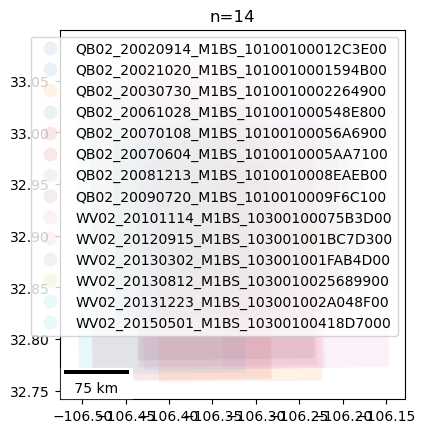

In [28]:
from matplotlib.patches import Patch
if 'Alaska' in BATCHNAME:
    # Do footprints intersect fires?
    fires_post_2010_gdf_intersects = fires_post_2010_gdf_clip_buf.to_crs(4326).overlay(footprint_gdf_intersect, how='intersection')

ax = footprint_gdf_intersect.plot(column='footprint_name', alpha=0.1, legend=True)

if 'Alaska' in BATCHNAME and fires_post_2010_gdf_intersects.shape[0] > 0:
    ax = fires_post_2010_gdf_intersects.boundary.plot(color='firebrick', ax=ax)
    
ax.set_title(label=f'n={len(footprint_gdf_intersect)}')
do_scalebar(ax)

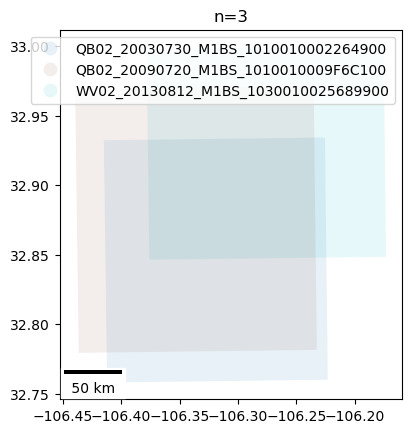

In [29]:
footprint_gdf_intersect_julyaug =  footprint_gdf_intersect[(footprint_gdf_intersect.month == 7) | (footprint_gdf_intersect.month == 8)]
if 'Alaska' in BATCHNAME:
    # Do footprints intersect fires?
    fires_post_2010_gdf_intersects_julyaug = fires_post_2010_gdf_clip_buf.to_crs(4326).overlay(footprint_gdf_intersect_julyaug, how='intersection')

ax = footprint_gdf_intersect_julyaug.plot(column='footprint_name', alpha=0.1, legend=True)

if 'Alaska' in BATCHNAME and fires_post_2010_gdf_intersects_julyaug.shape[0] > 0:
    ax = fires_post_2010_gdf_intersects_julyaug.boundary.plot(color='firebrick', ax=ax)
    
ax.set_title(label=f'n={len(footprint_gdf_intersect_julyaug)}') 
do_scalebar(ax)


# Map the target bounds, random points, buffered fires, and intersecting VHR footprints

In [30]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

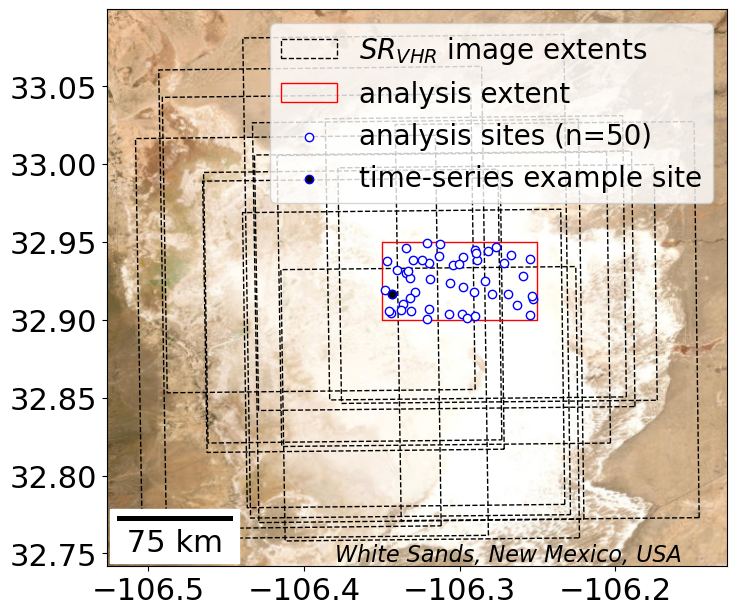

In [31]:
if 'Alaska' in BATCHNAME and fires_post_2010_gdf_intersects.shape[0] > 0:
    ax_target = fires_post_2010_gdf_intersects.to_crs(4326).plot(alpha=1, color='firebrick',figsize=(8, 8))
else:
    fig, ax_target = plt.subplots(nrows=1, ncols=1, figsize=(8, 8)) 
    
#def make_site_map(footprint_gdf_intersect, gdf_bounding_polygon, gdf_random_points, ax_target):

ax_target = footprint_gdf_intersect.to_crs(4326).plot(ax=ax_target, edgecolor='black', color='none', alpha=1, ls = '--')
ax_target = gdf_bounding_polygon.to_crs(4326).plot(ax=ax_target, edgecolor='red', color='none')
ax_target = gdf_random_points.to_crs(4326).plot(ax=ax_target, edgecolor='blue', color='white')
#ctx.add_basemap(ax,  source='https://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/tile/{z}/{y}/{x}', crs=4326)
ax_target.annotate('White Sands, New Mexico, USA', [-106.38,32.745], style= "italic", size=16)

#Label each point
for x, y, label in zip(gdf_random_points.lon, gdf_random_points.lat, gdf_random_points.site):
    if label == 33:
        ax_target = gdf_random_points[gdf_random_points.site==label].to_crs(4326).plot(ax=ax_target, edgecolor='blue', color='black')
        #ax_target.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='k', size=14)

do_scalebar(ax_target)
ax_target = ctx.add_basemap(ax_target, source='https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', crs=4326)
#return ax_target

#ax_target = make_site_map(footprint_gdf_intersect, gdf_bounding_polygon, gdf_random_points, ax_target)

#def make_plt_legend(SR_str):
plt.margins(y=0.5, x=0.5)
#plt.xlabel('Lon.')
#plt.ylabel('Lat.')

# adding legend with mpatches
import matplotlib.patches as mpatches
gray_patch = mpatches.Patch(edgecolor='black', facecolor='none', ls = '--', label=f'{SR_str} image extents')
red_patch = mpatches.Patch(edgecolor='red', fill=False, ls = '-', label='analysis extent')
points_marks = plt.scatter([],[], marker='o', color='white', edgecolor='blue', label=f'analysis sites (n={gdf_random_points.shape[0]})')
points_mark_time_series_example = plt.scatter([],[], marker='o', color='black', edgecolor='blue', label=f'time-series example site')

plt.legend(handles=[gray_patch, red_patch,points_marks, points_mark_time_series_example], fontsize=20)
#return plt

#plt = make_plt_legend(SR_str)
plt.savefig(os.path.join(OUTDIR, 'plots', f"map_imagery_sites_{SITE_ID_STRING}.png"))

# Save the plot as a variable
map_target = plt.gcf()

#    return ax_target

In [32]:
BASEMAP = 'World_Imagery' # 'NatGeo_World_Map'
TILES = f'https://server.arcgisonline.com/arcgis/rest/services/{BASEMAP}/MapServer/tile/'+'{z}/{y}/{x}'

if 'Alaska' in BATCHNAME and fires_post_2010_gdf_intersects.shape[0] > 0:
    FIRE_DESC = ''#'non-disturbed sites post-2010'
    m = fires_post_2010_gdf_intersects[['FireYear','IncidentName','GISAcres','geometry']].to_crs(4326).explore(style_kwds=dict(color="firebrick", weight=1, opacity=0.4, fillOpacity=.1), tiles=TILES, attr=' ')
else:
    FIRE_DESC=''
    m = gdf_bounding_polygon.to_crs(4326).explore(style_kwds=dict(color=None, opacity=0, fillOpacity=0), tiles=TILES, attr=' ')

In [33]:
m = footprint_gdf_intersect[['file', 'geometry']].to_crs(4326).explore(m=m, style_kwds=dict(color="black", weight=1, opacity=0.25, fillOpacity=0))
m = gdf_bounding_polygon.to_crs(4326).explore(m=m, style_kwds=dict(color="red", weight=2, opacity=0.4, fillOpacity=0.1))

# Find, rm datetime fields for plotting
DROP_LIST = gdf_random_points.select_dtypes(include=['datetime64[ns, UTC]']).columns.to_list()
gdf_random_points.drop(columns=DROP_LIST).to_crs(4326).explore(m=m,  style_kwds=dict(color="blue", radius=5, fill=True, weight=1, fillColor='white', fillOpacity=0.25)) #style_kwds=dict(color="white", weight=10, opacity=0.4, fillOpacity=1),

In [34]:
# m = maplib.MAP_LAYER_FOLIUM(LAYER=gdf_bounding_polygon, LAYER_COL_NAME='name', 
#                             lat_start=gdf_bounding_polygon.to_crs(4326).geometry.centroid.y, 
#                             lon_start=gdf_bounding_polygon.to_crs(4326).geometry.centroid.x)
# maplib.ADD_POINT_OBS_TO_MAP(gdf_random_points ,foliumMap=m)
# #maplib.MAP_LAYER_FOLIUM(LAYER=gdf_random_points[["geometry", "site"]].to_crs(3857), LAYER_COL_NAME='site', foliumMap=m)

### Subset the files list based on the intersections - TODO SELECTED_DICT

In [35]:
if 'Alaska' in BATCHNAME:
    print(BATCHNAME)
    selected_sr_list = ['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/srlite/002m/' + f for f in footprint_gdf_intersect.file.to_list()]
    selected_toa_list = ['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/toa/002m/' + os.path.basename(f).split('-sr')[0] + '-toa.tif' for f in selected_sr_list]
    selected_ccdc_list = ['/explore/nobackup/projects/above/misc/ABoVE_Shrubs/ccdc/030m/' + os.path.basename(f).split('-sr')[0] + '-ccdc.tif' for f in selected_sr_list]
else:
    print(f'\n~~~~This wont work if TOAs and CCDCs arent all in same dir...~~~\n')
    selected_sr_list = [f for f in SELECTED_DICT['f_sr_list'] if os.path.basename(f) in footprint_gdf_intersect.file.to_list() ]
    toa_dirname = os.path.dirname(SELECTED_DICT['f_toa_list'][0])
    selected_toa_list = [os.path.join(toa_dirname, os.path.basename(f).split('-sr')[0] + '-toa.tif') for f in selected_sr_list]
    ccdc_dirname = os.path.dirname(SELECTED_DICT['f_ccdc_list'][0])
    selected_ccdc_list = [os.path.join(ccdc_dirname, os.path.basename(f).split('-sr')[0] + '-ccdc.tif') for f in selected_sr_list]


~~~~This wont work if TOAs and CCDCs arent all in same dir...~~~



In [36]:
print(f"{len(selected_sr_list)} sr, {len(selected_toa_list)} toa, {len(selected_ccdc_list)} ccdc")

14 sr, 14 toa, 14 ccdc


In [37]:
#sorted(footprint_gdf_intersect.file.to_list())

#  Build the time series data frame
## Run the extraction of SRlite, TOA, and CCDC reflectance for each random point
##### return a time-series dataframe, plot

In [38]:
import plotnine
plotnine.options.figure_size = (24, 12)
# https://stackoverflow.com/questions/20571306/multi-row-x-axis-labels-in-ggplot-line-chart

In [39]:
bandnames_keys_list = list(BAND_RENAME_DICT.keys())
bandnames_keys_list
BAND_RENAME_DICT

{'BAND_B': 'BAND_B',
 'BAND_G': 'BAND_G',
 'BAND_R': 'BAND_R',
 'BAND_N': 'BAND_N'}

In [40]:
df_sr = get_ref_timeseries_table(gdf_random_points, selected_sr_list, batchname=BATCHNAME, DO_4BAND = True, CHG_YR_COLNAME=CHG_YR_COLNAME, CHG_NAME_COLNAME=CHG_NAME_COLNAME, DEBUG=False)
df_sr['type_ref'] = SR_str
df_sr.drop_duplicates(subset=['site','name']+bandnames_keys_list, keep='first', inplace=True)
df_sr.dropna(subset=bandnames_keys_list[0],inplace=True)
df_sr = df_sr.rename(columns=BAND_RENAME_DICT)
df_sr

site date_chg name_chg         lon        lat  \
0       1      NaT     None -106.312546  32.948479   
3       4      NaT     None -106.290134  32.944741   
4       5      NaT     None -106.334398  32.929895   
5       6      NaT     None -106.334401  32.946094   
6       7      NaT     None -106.344192  32.904425   
..    ...      ...      ...         ...        ...   
990    46      NaT     None -106.283748  32.924690   
992    47      NaT     None -106.318829  32.926137   
994    48      NaT     None -106.297993  32.921377   
996    49      NaT     None -106.295329  32.901271   
998    50      NaT     None -106.331515  32.905395   

                                       geometry    batchname sensor  \
0     [(377311.79253826494, 3646339.765059116)]  White Sands   QB02   
3     [(379401.7754426856, 3645899.4605010427)]  White Sands   QB02   
4      [(375242.948187632, 3644304.9731549197)]  White Sands   QB02   
5    [(375265.46981681534, 3646100.9496562993)]  White Sands   QB02   
6      [(374291.2448044284, 3641492.679784114)]  White Sands   QB02   
..                                          ...          ...    ...   
990  [(379971.71233982465, 3643669.0389396683)]  White Sands   WV02   
992  [(376693.45735828415, 3643869.9545481238)]  White Sands   WV02   
994    [(378635.1720560505, 3643318.069613688)]  White Sands   WV02   
996   [(378856.9126060132, 3641085.8378505423)]  White Sands   WV02   
998  [(375478.25175280485, 3641585.1762197744)]  White Sands   WV02   

                                    name       date  BAND_B  BAND_G  BAND_R  \
0    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.6046  0.5651  0.6815   
3    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.5567  0.5276  0.6367   
4    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.5378  0.5190  0.6179   
5    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.2371  0.3113  0.2810   
6    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.5174  0.5041  0.5849   
..                                   ...        ...     ...     ...     ...   
990  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5582  0.5744  0.6939   
992  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5558  0.5709  0.6813   
994  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.4991  0.5181  0.5864   
996  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5526  0.5637  0.6671   
998  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5023  0.5265  0.6089   

     BAND_N  year  month    type_ref  
0    0.6689  2002      9  $SR_{VHR}$  
3    0.6223  2002      9  $SR_{VHR}$  
4    0.6315  2002      9  $SR_{VHR}$  
5    0.3909  2002      9  $SR_{VHR}$  
6    0.5965  2002      9  $SR_{VHR}$  
..      ...   ...    ...         ...  
990  0.6913  2012      9  $SR_{VHR}$  
992  0.6758  2012      9  $SR_{VHR}$  
994  0.5860  2012      9  $SR_{VHR}$  
996  0.6639  2012      9  $SR_{VHR}$  
998  0.6178  2012      9  $SR_{VHR}$  

[575 rows x 17 columns]

In [41]:
df_toa = get_ref_timeseries_table(gdf_random_points, selected_toa_list, batchname=BATCHNAME, DO_4BAND = True, CHG_YR_COLNAME=CHG_YR_COLNAME, CHG_NAME_COLNAME=CHG_NAME_COLNAME, DEBUG=False)
df_toa['type_ref'] = TOA_str
df_toa[df_toa == -1.0001] = np.nan
df_toa.drop_duplicates(subset=['site','name']+bandnames_keys_list, keep='first', inplace=True)
df_toa.dropna(subset=bandnames_keys_list[0], inplace=True)
df_toa = df_toa.rename(columns=BAND_RENAME_DICT)
df_toa

site date_chg name_chg         lon        lat  \
0       1      NaT     None -106.312546  32.948479   
3       4      NaT     None -106.290134  32.944741   
4       5      NaT     None -106.334398  32.929895   
5       6      NaT     None -106.334401  32.946094   
6       7      NaT     None -106.344192  32.904425   
..    ...      ...      ...         ...        ...   
990    46      NaT     None -106.283748  32.924690   
992    47      NaT     None -106.318829  32.926137   
994    48      NaT     None -106.297993  32.921377   
996    49      NaT     None -106.295329  32.901271   
998    50      NaT     None -106.331515  32.905395   

                                       geometry    batchname sensor  \
0     [(377311.79253826494, 3646339.765059116)]  White Sands   QB02   
3     [(379401.7754426856, 3645899.4605010427)]  White Sands   QB02   
4      [(375242.948187632, 3644304.9731549197)]  White Sands   QB02   
5    [(375265.46981681534, 3646100.9496562993)]  White Sands   QB02   
6      [(374291.2448044284, 3641492.679784114)]  White Sands   QB02   
..                                          ...          ...    ...   
990  [(379971.71233982465, 3643669.0389396683)]  White Sands   WV02   
992  [(376693.45735828415, 3643869.9545481238)]  White Sands   WV02   
994    [(378635.1720560505, 3643318.069613688)]  White Sands   WV02   
996   [(378856.9126060132, 3641085.8378505423)]  White Sands   WV02   
998  [(375478.25175280485, 3641585.1762197744)]  White Sands   WV02   

                                    name       date  BAND_B  BAND_G  BAND_R  \
0    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.5410  0.5719  0.6454   
3    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.5062  0.5282  0.6063   
4    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.4924  0.5181  0.5900   
5    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.2738  0.2759  0.2965   
6    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  0.4776  0.5008  0.5612   
..                                   ...        ...     ...     ...     ...   
990  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5672  0.6076  0.6881   
992  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5654  0.6038  0.6778   
994  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5234  0.5459  0.6004   
996  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5630  0.5959  0.6662   
998  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  0.5258  0.5551  0.6187   

     BAND_N  year  month     type_ref  
0    0.6610  2002      9  $TOA_{VHR}$  
3    0.6074  2002      9  $TOA_{VHR}$  
4    0.6180  2002      9  $TOA_{VHR}$  
5    0.3412  2002      9  $TOA_{VHR}$  
6    0.5778  2002      9  $TOA_{VHR}$  
..      ...   ...    ...          ...  
990  0.7164  2012      9  $TOA_{VHR}$  
992  0.6998  2012      9  $TOA_{VHR}$  
994  0.6037  2012      9  $TOA_{VHR}$  
996  0.6871  2012      9  $TOA_{VHR}$  
998  0.6377  2012      9  $TOA_{VHR}$  

[575 rows x 17 columns]

In [42]:
df_ccdc = get_ref_timeseries_table(gdf_random_points, selected_ccdc_list, batchname=BATCHNAME, DO_4BAND = True, CHG_YR_COLNAME=CHG_YR_COLNAME, CHG_NAME_COLNAME=CHG_NAME_COLNAME)
df_ccdc['type_ref'] = SR_ref_str 
#df_ccdc[df_ccdc == -1.0001] = np.nan
df_ccdc = df_ccdc.rename(columns={'blue_ccdc': 'BAND_B', 'green_ccdc': 'BAND_G', 'red_ccdc': 'BAND_R', 'nir_ccdc': 'BAND_N'})
df_ccdc.drop_duplicates(subset=['site','name','BAND_B','BAND_G','BAND_R','BAND_N'], keep='first', inplace=True)
df_ccdc.dropna(subset=['BAND_B'], inplace=True)
df_ccdc = df_ccdc.rename(columns=BAND_RENAME_DICT)
df_ccdc

site date_chg name_chg         lon        lat  \
0       1      NaT     None -106.312546  32.948479   
2       3      NaT     None -106.276801  32.946975   
3       4      NaT     None -106.290134  32.944741   
4       5      NaT     None -106.334398  32.929895   
5       6      NaT     None -106.334401  32.946094   
..    ...      ...      ...         ...        ...   
988    45      NaT     None -106.324122  32.938548   
992    47      NaT     None -106.318829  32.926137   
994    48      NaT     None -106.297993  32.921377   
996    49      NaT     None -106.295329  32.901271   
998    50      NaT     None -106.331515  32.905395   

                                       geometry    batchname sensor  \
0     [(377311.79253826494, 3646339.765059116)]  White Sands   QB02   
2       [(380651.246055239, 3646131.911223958)]  White Sands   QB02   
3     [(379401.7754426856, 3645899.4605010427)]  White Sands   QB02   
4      [(375242.948187632, 3644304.9731549197)]  White Sands   QB02   
5    [(375265.46981681534, 3646100.9496562993)]  White Sands   QB02   
..                                          ...          ...    ...   
988  [(376215.82351482136, 3645252.2610935178)]  White Sands   WV02   
992  [(376693.45735828415, 3643869.9545481238)]  White Sands   WV02   
994    [(378635.1720560505, 3643318.069613688)]  White Sands   WV02   
996   [(378856.9126060132, 3641085.8378505423)]  White Sands   WV02   
998  [(375478.25175280485, 3641585.1762197744)]  White Sands   WV02   

                                    name       date  ...  BAND_N  \
0    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6782   
2    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6965   
3    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6973   
4    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6501   
5    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.5094   
..                                   ...        ...  ...     ...   
988  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6834   
992  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6940   
994  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.7735   
996  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6915   
998  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6658   

     blue_nearestDate  green_nearestDate  red_nearestDate  nir_nearestDate  \
0              1.0000             0.5618           0.6306           0.6688   
2              1.0000             0.5437           0.6273           0.6648   
3              1.0000             0.5582           0.6244           0.6724   
4              1.0000             0.5118           0.5675           0.6198   
5              0.2796             0.3217           0.3476           0.4142   
..                ...                ...              ...              ...   
988            0.4969             0.5888           1.0000           0.6762   
992            0.5198             0.6177           1.0000           0.7119   
994            1.0000             0.6465           1.0000           0.7296   
996            0.5197             0.6177           1.0000           0.6974   
998            0.4484             0.5473           0.6116           0.6398   

     dateDiff_nearestDate  water_occurrence  year  month          type_ref  
0                 -0.0001               0.0  2002      9  $SR_{reference}$  
2                 -0.0001               0.0  2002      9  $SR_{reference}$  
3                 -0.0001               0.0  2002      9  $SR_{reference}$  
4                 -0.0001               0.0  2002      9  $SR_{reference}$  
5                 -0.0001               0.0  2002      9  $SR_{reference}$  
..                    ...               ...   ...    ...               ...  
988               -0.0015               0.0  2012      9  $SR_{reference}$  
992               -0.0015               0.0  2012      9  $SR_{reference}$  
994               -0.0015               0.0  2012      9

In [43]:
# fpath = SELECTED_DICT['f_toa_list'][0]
# with rasterio.open(fpath) as src:
#     bandnames_list = [b.replace('-','_') for b in list(src.descriptions)]
#     print(bandnames_list)

#### Number of images from this time-series (max number differs for each random point being examined)

In [44]:
g = df_toa.dropna(subset=['BAND_B']).groupby('name')
print(f'# of image strips contributing: {len(list(g.groups))}')

# of image strips contributing: 14


## Build & save a combined data frame of extracted reflectance values for random points over intersecting VHR 

In [45]:
SITE_ID_STRING

'WhiteSands_-106.35_32.90_-106.25_32.95_20240821'

In [46]:
df_combined = pd.concat([df_sr.dropna(subset=['BAND_B']), df_toa.dropna(subset=['BAND_B']), df_ccdc.dropna(subset=['BAND_B'])])
df_combined['type_ref'] = df_combined['type_ref'].astype('category').cat.reorder_categories([SR_str, TOA_str, SR_ref_str])
#df_combined = df_combined.drop(columns=['blue_nearestDate','green_nearestDate','red_nearestDate','nir_nearestDate','dateDiff_nearestDate','water_occurrence'])

out_df_combined_fn = os.path.join(OUTDIR, 'data', f"data_n{len(df_combined):05}_{SITE_ID_STRING}.csv")

df_combined.to_csv(out_df_combined_fn)
df_combined.head()

site date_chg name_chg         lon        lat  \
0     1      NaT     None -106.312546  32.948479   
3     4      NaT     None -106.290134  32.944741   
4     5      NaT     None -106.334398  32.929895   
5     6      NaT     None -106.334401  32.946094   
6     7      NaT     None -106.344192  32.904425   

                                     geometry    batchname sensor  \
0   [(377311.79253826494, 3646339.765059116)]  White Sands   QB02   
3   [(379401.7754426856, 3645899.4605010427)]  White Sands   QB02   
4    [(375242.948187632, 3644304.9731549197)]  White Sands   QB02   
5  [(375265.46981681534, 3646100.9496562993)]  White Sands   QB02   
6    [(374291.2448044284, 3641492.679784114)]  White Sands   QB02   

                                  name       date  ...  BAND_N  year  month  \
0  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6689  2002      9   
3  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6223  2002      9   
4  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6315  2002      9   
5  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.3909  2002      9   
6  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.5965  2002      9   

     type_ref  blue_nearestDate  green_nearestDate red_nearestDate  \
0  $SR_{VHR}$               NaN                NaN             NaN   
3  $SR_{VHR}$               NaN                NaN             NaN   
4  $SR_{VHR}$               NaN                NaN             NaN   
5  $SR_{VHR}$               NaN                NaN             NaN   
6  $SR_{VHR}$               NaN                NaN             NaN   

   nir_nearestDate  dateDiff_nearestDate  water_occurrence  
0              NaN                   NaN               NaN  
3              NaN                   NaN               NaN  
4              NaN                   NaN               NaN  
5              NaN                   NaN               NaN  
6              NaN                   NaN               NaN  

[5 rows x 23 columns]

## Summarize sites: get list of site with multiple summer obs

In [47]:
MONTH_MIN = 6
MONTH_MAX = 9

smry_site_summer_year_cnt = df_combined[(df_combined.type_ref == TOA_str) & ((df_combined.month >= MONTH_MIN) & (df_combined.month <= MONTH_MAX) )].\
                                            groupby(['site','month','year']).\
                                            aggregate({'month':'count'}).\
                                            rename(columns={'month': 'cnt_obs'}).\
                                            reset_index().groupby(['site']).aggregate({'site':'count'}).rename(columns={'site': 'cnt_obs'}).reset_index()

list_sites_with_multiple_summer_obs_across_multiple_years = list(set(smry_site_summer_year_cnt[smry_site_summer_year_cnt.cnt_obs > 1].reset_index().site.to_list()))

smry_site_summer_year_cnt.head(10)

site  cnt_obs
0     1        5
1     2        4
2     3        4
3     4        5
4     5        6
5     6        5
6     7        6
7     8        5
8     9        6
9    10        5

## Subset data frame with list of sites

Data frame with sites that have enough obs for a robust time-series
 - multiple years of obs in summer  
 - still includes all obs for these sites  
 - removes sites that have only a single summer obs across all years

In [48]:
print(f"{df_combined.shape}")
df_combined_sub = df_combined[df_combined.site.isin(list_sites_with_multiple_summer_obs_across_multiple_years)]
print(f"{len(list_sites_with_multiple_summer_obs_across_multiple_years)} sites with summer obs across multiple years")
print(f"{df_combined_sub.shape}")

(1743, 23)
50 sites with summer obs across multiple years
(1743, 23)


In [49]:
df_combined_sub

site date_chg name_chg         lon        lat  \
0       1      NaT     None -106.312546  32.948479   
3       4      NaT     None -106.290134  32.944741   
4       5      NaT     None -106.334398  32.929895   
5       6      NaT     None -106.334401  32.946094   
6       7      NaT     None -106.344192  32.904425   
..    ...      ...      ...         ...        ...   
988    45      NaT     None -106.324122  32.938548   
992    47      NaT     None -106.318829  32.926137   
994    48      NaT     None -106.297993  32.921377   
996    49      NaT     None -106.295329  32.901271   
998    50      NaT     None -106.331515  32.905395   

                                       geometry    batchname sensor  \
0     [(377311.79253826494, 3646339.765059116)]  White Sands   QB02   
3     [(379401.7754426856, 3645899.4605010427)]  White Sands   QB02   
4      [(375242.948187632, 3644304.9731549197)]  White Sands   QB02   
5    [(375265.46981681534, 3646100.9496562993)]  White Sands   QB02   
6      [(374291.2448044284, 3641492.679784114)]  White Sands   QB02   
..                                          ...          ...    ...   
988  [(376215.82351482136, 3645252.2610935178)]  White Sands   WV02   
992  [(376693.45735828415, 3643869.9545481238)]  White Sands   WV02   
994    [(378635.1720560505, 3643318.069613688)]  White Sands   WV02   
996   [(378856.9126060132, 3641085.8378505423)]  White Sands   WV02   
998  [(375478.25175280485, 3641585.1762197744)]  White Sands   WV02   

                                    name       date  ...  BAND_N  year  month  \
0    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6689  2002      9   
3    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6223  2002      9   
4    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6315  2002      9   
5    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.3909  2002      9   
6    QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.5965  2002      9   
..                                   ...        ...  ...     ...   ...    ...   
988  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6834  2012      9   
992  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6940  2012      9   
994  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.7735  2012      9   
996  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6915  2012      9   
998  WV02_20120915_M1BS_103001001BC7D300 2012-09-15  ...  0.6658  2012      9   

             type_ref  blue_nearestDate  green_nearestDate red_nearestDate  \
0          $SR_{VHR}$               NaN                NaN             NaN   
3          $SR_{VHR}$               NaN                NaN             NaN   
4          $SR_{VHR}$               NaN                NaN             NaN   
5          $SR_{VHR}$               NaN                NaN             NaN   
6          $SR_{VHR}$               NaN                NaN             NaN   
..                ...               ...                ...             ...   
988  $SR_{reference}$            0.4969             0.5888          1.0000   
992  $SR_{reference}$            0.5198             0.6177          1.0000   
994  $SR_{reference}$            1.0000             0.6465          1.0000   
996  $SR_{reference}$            0.5197             0.6177          1.0000   
998  $SR_{reference}$            0.4484             0.5473          0.6116   

     nir_nearestDate  dateDiff_nearestDate  water_occurrence  
0                NaN                   NaN               NaN  
3                NaN                   NaN               NaN  
4                NaN                   NaN               NaN  
5                NaN                   NaN               NaN  
6                NaN                   NaN               NaN  
..               ...                   ...               ...  
988           0.6762               -0.0015               0.0  
992           0.7119               -0.0015               0.0  
994           0.7296      

# Plot time-series

In [50]:
def plot_timeseries(df, BANDSLIST = ["BAND_B","BAND_G","BAND_R","BAND_N"], YLIMS = (0.20,0.75), DO_NAMES = False, BAND_RENAME_DICT=None, SHOW_REFERENCE=True):
    
    if not SHOW_REFERENCE:
        df = df[df.type_ref != SR_ref_str]
    
    df_m = pd.melt(df, id_vars=["site","geometry","batchname","name","date","year","date_chg","name_chg",'sensor','lon','lat','type_ref'], value_vars=BANDSLIST)
    #df_m = pd.melt(df, id_vars=["site","geometry","batchname","name","date","year",'sensor','lon','lat','type_ref'], value_vars=BANDSLIST)
    if BAND_RENAME_DICT is not None:
        df_m['variable'] = df_m['variable'].astype('category').cat.rename_categories(BAND_RENAME_DICT).cat.reorder_categories(['blue', 'green','red','nir'])
    
    if pd.isnull(df.date_chg.min()) and pd.isnull(df.date_chg.max()):
        HAS_DISTURBANCE = False
        df_m['date_chg'] = 'None'
        df_m['name_chg'] = 'None'
        df_m['date_chg_end'] = 'None'
        df_m['date_chg_mid'] = 'None'
    else:
        # There will be a mix of sites that are disturbed/undisturbed
        HAS_DISTURBANCE = True
        df_m['date_chg_end'] = df_m['date_chg'] + pd.Timedelta(days=364)
        df_m['date_chg_mid'] = df_m['date_chg'] + pd.Timedelta(days=182)
        
        # Handle undisturbed: to eliminate nulls (NaT values) set all data chg fields to date...?
        # otherwise, sites with NaT (undisturbed sites) get dropped
        
        df_m.loc[df_m['date_chg'].isnull(), 'date_chg_end'] = df_m.date_chg_end.max()
        df_m.loc[df_m['date_chg'].isnull(), 'date_chg_mid'] = df_m.date_chg_end.max()
        df_m.loc[df_m['date_chg'].isnull(), 'name_chg'] = ''
        df_m.loc[df_m['date_chg'].isnull(), 'date_chg'] = df_m.date_chg_end.max()
        
    # Use dropna() to ensure all points in time are connected with a line
    p = (
        ggplot(df_m.dropna(), aes(x="date", y='value', color='variable', group='variable', 
                                  #linetype='sensor', 
                                  shape="sensor"))
        + labs(y='Reflectance', x=None)
    )
    if HAS_DISTURBANCE:
        print('These sites feature disturbances')
        p = (
            p + geom_rect(aes(xmin='date_chg', xmax= 'date_chg_end', ymin=-float("inf"), ymax=float("inf")), fill='gray', color='none', alpha=0.01, linetype='--')
              + geom_label(aes(x='date_chg_mid', y=(YLIMS[1]-YLIMS[0])/2, label='name_chg'),size=10, angle=90, color='black')
            )
    p = (
        p + geom_line(aes(x="date", y='value', color='variable'), alpha=0.1, size=10)
          + geom_line(size=1.5, alpha=0.5)
          + geom_point(size=6)#, shape='o')
        #+ geom_text(aes(label='name'), angle=90, size=5)
        + scale_color_manual(values = ('royalblue', 'forestgreen', 'orangered', 'firebrick'), name='Band')
        + scale_x_datetime(breaks=date_breaks('3 months'), labels=date_format('%Y %b-%d'))        # new
        + coord_cartesian(ylim = YLIMS)
        + theme(axis_text_x = element_text(rotation=90, size=8), strip_text_x = element_text(size=14), strip_text_y = element_text(size=6))
        + facet_grid('site+lon+lat ~ type_ref+batchname')
        + theme_bw()
        )

    if DO_NAMES:
        p = p + geom_text(aes(label='name'), angle=90, size=5)
    return p

#### Subset to summer

In [51]:
SUBSET_TO_SUMMER = True
SAMPLE_SITES = False # not handled correctly yet

print(f"{df_combined_sub.shape}")
if SUBSET_TO_SUMMER: 
    SEASONALITY = 'summer'
    OBS_DESCR = f'{FIRE_DESC}months {MONTH_MIN}-{MONTH_MAX}'
    df_plot = df_combined_sub[(df_combined_sub.month >= MONTH_MIN) & (df_combined_sub.month <= MONTH_MAX)]
else:
    SEASONALITY = ''
    OBS_DESCR = f'{FIRE_DESC}all months'
    df_plot = df_combined_sub
print(f"{df_plot.shape}")
OBS_DESCR

(1743, 23)
(809, 23)


'months 6-9'

#### Set sites to plot

In [52]:
list_sites_to_plot = list_sites_with_multiple_summer_obs_across_multiple_years
n_sites = 'n_all'
if SAMPLE_SITES:
    
    print(f"{df_plot.shape}")
    N_RANDOM_SITES_TO_PLOT = 10
    n_sites = f'n_{N_RANDOM_SITES_TO_PLOT:02}' 
    print(f"{N_RANDOM_SITES_TO_PLOT} random sites for plotting...")

    list_sites_to_plot = random.sample(set(df_plot.site.to_list()), N_RANDOM_SITES_TO_PLOT)
    df_plot = df_plot[df_plot.site.isin(list_sites_to_plot)]
    print(f"{df_plot.shape}")
    
print(list_sites_to_plot)
print(n_sites)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
n_all


### multi-facetted by site
Note:  
These strips could still have bad data (clouds)   
They have not been check for bad srlite metrics (need to run performance metrics)

In [53]:
df_plot.head()

site date_chg name_chg         lon        lat  \
0     1      NaT     None -106.312546  32.948479   
3     4      NaT     None -106.290134  32.944741   
4     5      NaT     None -106.334398  32.929895   
5     6      NaT     None -106.334401  32.946094   
6     7      NaT     None -106.344192  32.904425   

                                     geometry    batchname sensor  \
0   [(377311.79253826494, 3646339.765059116)]  White Sands   QB02   
3   [(379401.7754426856, 3645899.4605010427)]  White Sands   QB02   
4    [(375242.948187632, 3644304.9731549197)]  White Sands   QB02   
5  [(375265.46981681534, 3646100.9496562993)]  White Sands   QB02   
6    [(374291.2448044284, 3641492.679784114)]  White Sands   QB02   

                                  name       date  ...  BAND_N  year  month  \
0  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6689  2002      9   
3  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6223  2002      9   
4  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.6315  2002      9   
5  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.3909  2002      9   
6  QB02_20020914_M1BS_10100100012C3E00 2002-09-14  ...  0.5965  2002      9   

     type_ref  blue_nearestDate  green_nearestDate red_nearestDate  \
0  $SR_{VHR}$               NaN                NaN             NaN   
3  $SR_{VHR}$               NaN                NaN             NaN   
4  $SR_{VHR}$               NaN                NaN             NaN   
5  $SR_{VHR}$               NaN                NaN             NaN   
6  $SR_{VHR}$               NaN                NaN             NaN   

   nir_nearestDate  dateDiff_nearestDate  water_occurrence  
0              NaN                   NaN               NaN  
3              NaN                   NaN               NaN  
4              NaN                   NaN               NaN  
5              NaN                   NaN               NaN  
6              NaN                   NaN               NaN  

[5 rows x 23 columns]

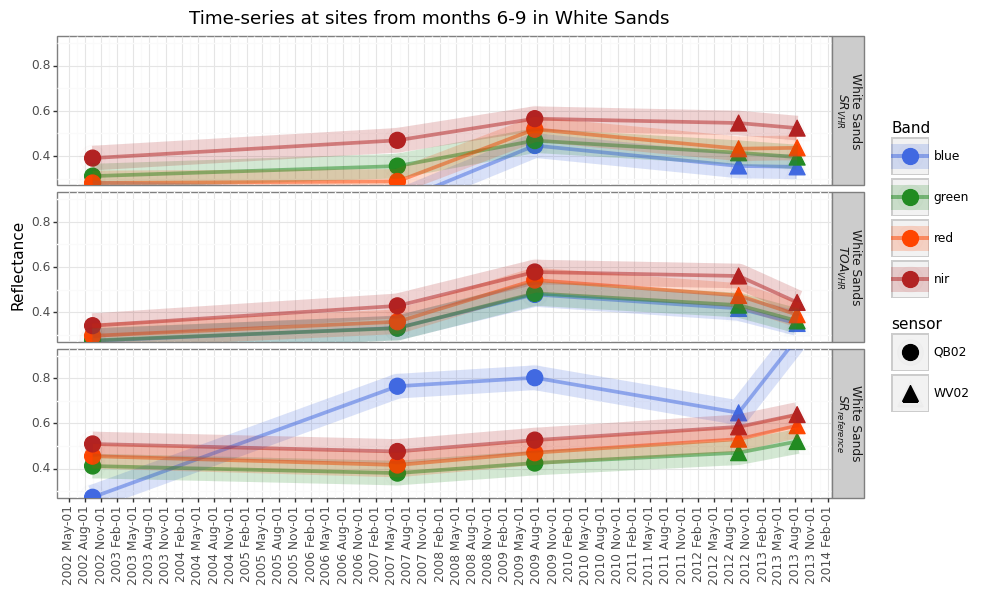

<ggplot: (1462392072566)>

In [54]:
(
            plot_timeseries(df_plot[df_plot.site == 6], YLIMS = (0.3, 0.9), BAND_RENAME_DICT=BAND_RENAME_DICT_forPLOT, SHOW_REFERENCE=True)                 
                + theme_bw() 
                + theme(axis_text_x=element_text(angle=90))
                + labs(title=f'Time-series at sites from {OBS_DESCR} in {BATCHNAME} ')
                + geom_point(aes(x="date", y='value', color='variable', group='site'), alpha=0.01, size=10)
                + geom_line(aes(x="date", y='value', color='variable'), alpha=0.1, size=10)
                    + theme(
        figure_size = (10, 6)
           )
    + facet_grid('type_ref+batchname~.')           
)

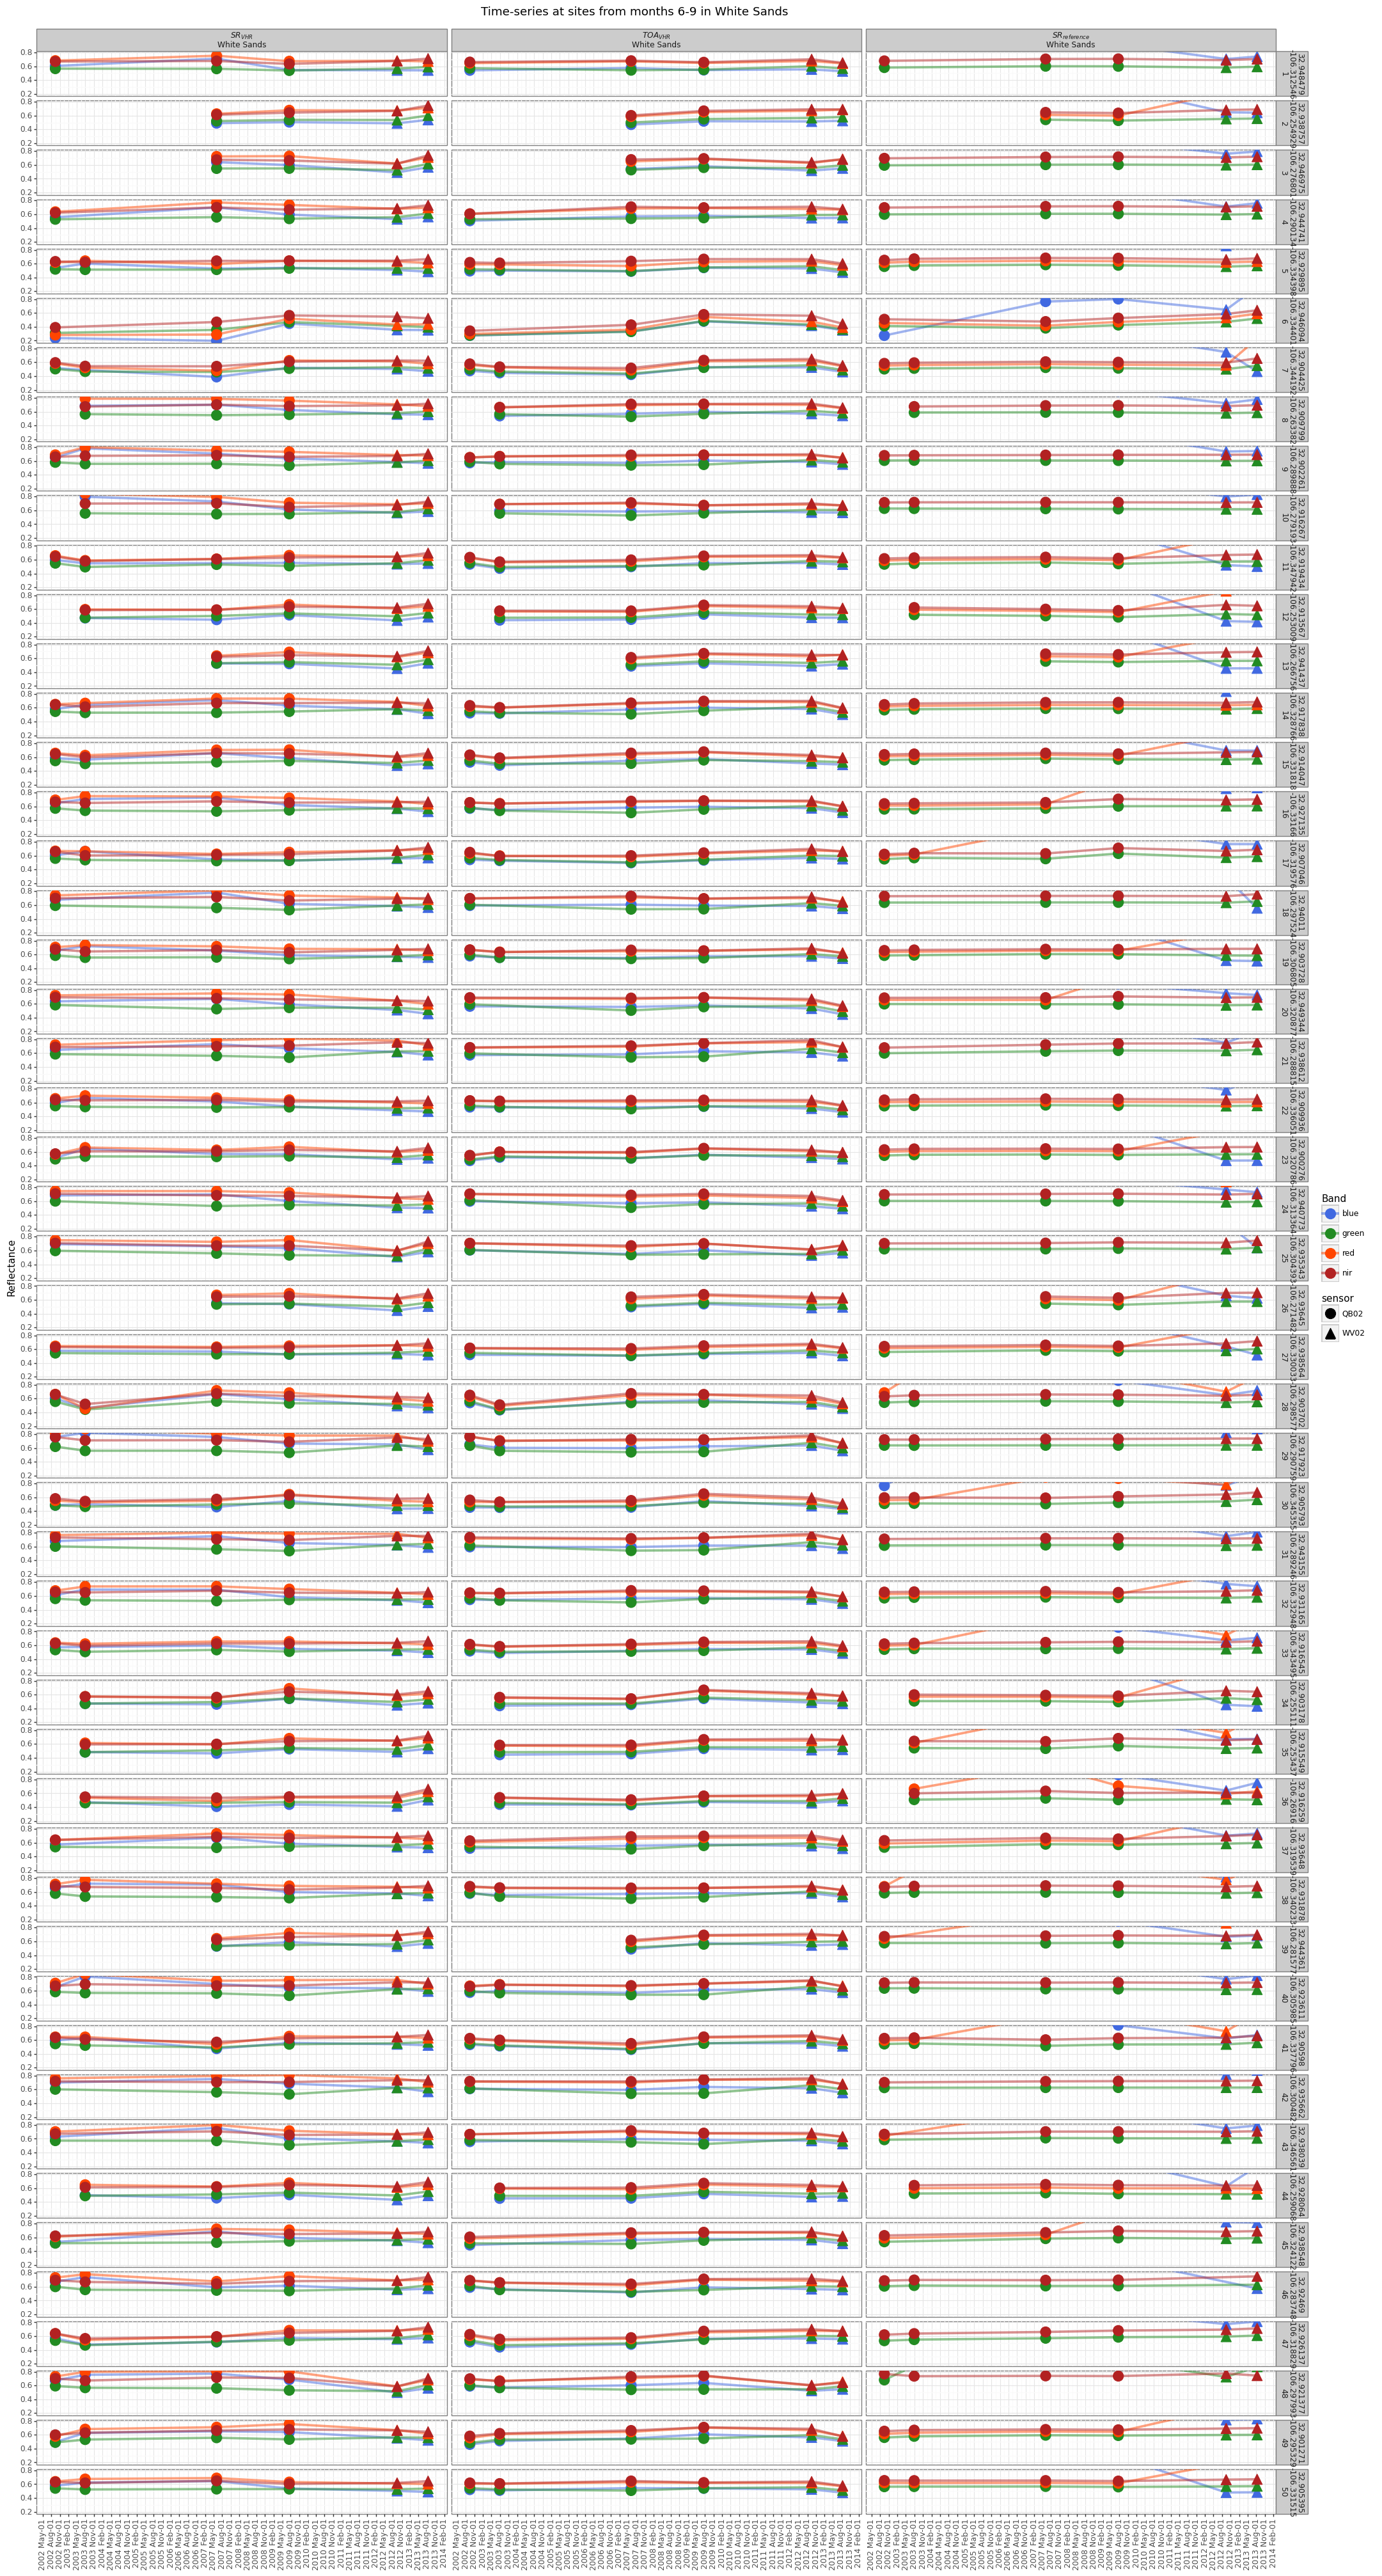

In [309]:
# import warnings
# warnings.filterwarnings('ignore')
plotnine.options.figure_size = (25, (len(list_sites_to_plot)))

fig, p = (
            plot_timeseries(df_plot, YLIMS = (df_plot.BAND_B.min(), df_plot.BAND_N.max()), BAND_RENAME_DICT=BAND_RENAME_DICT_forPLOT, SHOW_REFERENCE=True)                 
                + theme_bw() 
                + theme(axis_text_x=element_text(angle=90))
                + labs(title=f'Time-series at sites from {OBS_DESCR} in {BATCHNAME} ')
            ).draw(show=False, return_ggplot=True)
SITE_ID_STRING
fig.savefig(os.path.join(OUTDIR, 'plots', f"plot_timeseries_refl_{n_sites}{SEASONALITY}_{SITE_ID_STRING}.png"), dpi=300)
df_plot.to_csv(os.path.join(OUTDIR, 'plots', f"plot_timeseries_refl_{n_sites}{SEASONALITY}_{SITE_ID_STRING}_data.csv"))

In [55]:
# Get catids for a site
set(sorted(df_plot[df_plot.site == 21].name.to_list()))
SITE_NUM = list_sites_to_plot[37]
SITE_NUM = 33 #5 #48

                                     name
name                                     
QB02_20020914_M1BS_10100100012C3E00     3
QB02_20030730_M1BS_1010010002264900     3
QB02_20070604_M1BS_1010010005AA7100     3
QB02_20090720_M1BS_1010010009F6C100     3
WV02_20120915_M1BS_103001001BC7D300     3
WV02_20130812_M1BS_1030010025689900     3
Site 33: White Sands


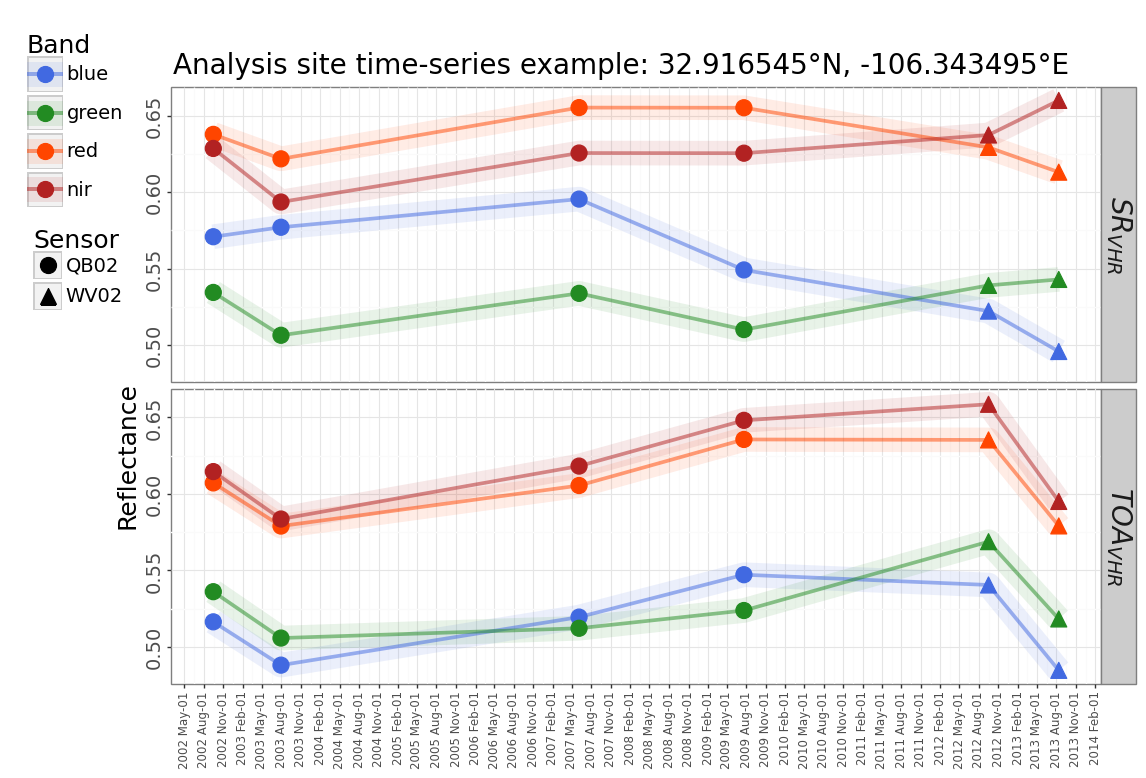

In [56]:
#plotnine.options.figure_size = (22, 10)

site_df = df_plot[df_plot.site == SITE_NUM]

print(site_df.groupby('name').agg({'name': 'count'}))

YLIMS = (site_df.BAND_B.min(), site_df.BAND_N.max())
print(f"Site {SITE_NUM}: {BATCHNAME}")
plot_object = (
    plot_timeseries(site_df, YLIMS = YLIMS, BAND_RENAME_DICT=BAND_RENAME_DICT_forPLOT, SHOW_REFERENCE=False)  
    + theme_bw() 
    + guides(color=guide_legend(title='Band', ncol=1))
    + guides(linetype=guide_legend(title='Sensor', ncol=1))
    + guides(shape=guide_legend(title='Sensor', ncol=1))
    + theme(
        figure_size = (12, 7.75),
        #figure_size = (16, 14),
        # text = element_text(size=26),
        plot_title=element_text(size=20),
         axis_text_x=element_text(angle=90, size=8.5), 
         axis_text_y=element_text(angle=90, size=14),#, size=24),
         axis_title_y=element_text(size=18, hjust=1),
         strip_text_y=element_text(size=20),
        legend_position=(0.045, 0.775), 
        #legend_position=(1, 0.70), 
        legend_direction='horizontal',
        legend_box='vertical', 
         legend_title=element_text(size=18),
         legend_text = element_text(size=14),
        legend_background = element_rect(colour = '', fill = '')
           )
    + facet_grid('type_ref ~ .')
    + labs(title=f'Analysis site time-series example: {list(set(site_df.lat.to_list()))[0]}°N, {list(set(site_df.lon.to_list()))[0]}°E')
    #+ scale_x_discrete() 
    # Image Name Label
    #+ geom_label(aes(x='date', y=(YLIMS[1]-YLIMS[0])/2, label='name'),size=10, angle=90, nudge_x=30, alpha=0.25, color='black')
)

fig_time_series_site, p = plot_object.draw(show=True, return_ggplot=True)

fig_time_series_site.savefig(os.path.join(OUTDIR, 'plots', f"plot_timeseries_refl_site{SITE_NUM:03}{SEASONALITY}_{SITE_ID_STRING}.png"), dpi=400)

In [57]:
for NAME in site_df.name.to_list():
    [print(s) for s in f_sr_list_match if NAME in s]

/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/QB02_20020914_M1BS_10100100012C3E00-sr-02m.tif
/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/QB02_20030730_M1BS_1010010002264900-sr-02m.tif
/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/QB02_20070604_M1BS_1010010005AA7100-sr-02m.tif
/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/QB02_20090720_M1BS_1010010009F6C100-sr-02m.tif
/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/WV02_20130812_M1BS_1030010025689900-sr-02m.tif
/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/WV02_20120915_M1BS_103001001BC7D300-sr-02m.tif
/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesan

In [58]:
from shapely.geometry import Point
site_gdf = gpd.GeoDataFrame(site_df[['site','batchname','geometry']], crs="EPSG:4326", geometry=[Point(xy) for xy in zip(site_df.lon, site_df.lat)])

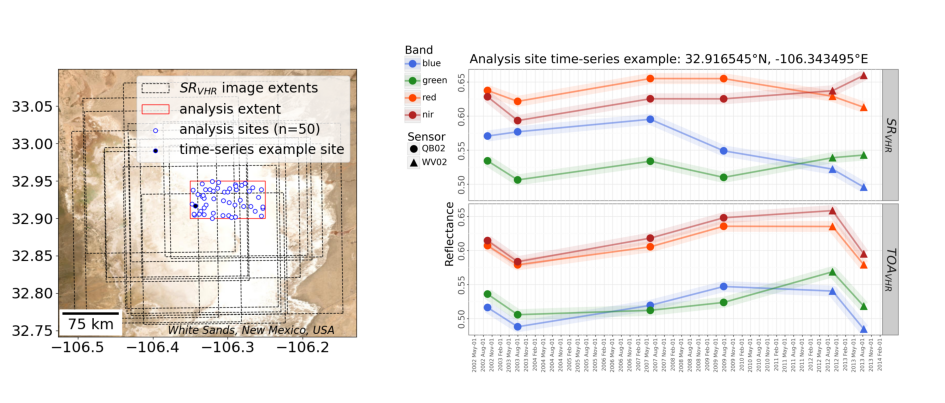

In [59]:
# Read the saved plots using PIL
plot1 = mpimg.imread(os.path.join(OUTDIR, 'plots', f"map_imagery_sites_{SITE_ID_STRING}.png"))
plot2 = mpimg.imread(os.path.join(OUTDIR, 'plots', f"plot_timeseries_refl_site{SITE_NUM:03}{SEASONALITY}_{SITE_ID_STRING}.png"))

# Create a figure with two subplots side by side
#fig, axs = plt.subplots(1, 2, figsize=(12, 10))
fig, axs = plt.subplots(1, 2, 
                        figsize=(10, 4.5), 
                        gridspec_kw={'width_ratios': [1.5, 2], 'wspace':0, 'hspace':0}
                       )

# Display the first plot on the left subplot
axs[0].imshow(plot1)
axs[0].axis('off')  # Optional: Turn off axis labels and ticks for cleaner display

# Display the second plot on the right subplot
axs[1].imshow(plot2)
# Convert plotnine plot to matplotlib subplot
#p.draw(axs[1])
axs[1].axis('off')  # Optional: Turn off axis labels and ticks for cleaner display <-- THIS IS CLIPPING LEGEND TEXT, even when set to 'off' (just invisible)

# Adjust layout to prevent clipping of subplot titles
plt.tight_layout()
fig.savefig(os.path.join(OUTDIR, 'plots', f"figure_multiplot_map_{BATCHNAME}_timeseries_refl_site{SITE_NUM:03}{SEASONALITY}_{SITE_ID_STRING}.tif"), dpi=600)

In [60]:
OUTDIR

'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss'

## Plot slopes

Use a variety of data subsets  
 - all  
 - subset of summer obs across multiple years to capture slope of time-series  
 - subset for plots above

In [61]:
df_list =           [df_combined, df_combined_sub, df_plot]
df_name_list =      ['all sites, obs.', 'subset: sites with summer obs across multiple yrs', 'random sample of subset']
df_shortname_list = ['all', 'subset', 'subset_randsamp']
smry_df_list = []

## For non-changing sites, slope should be 0
SRlite more likely to have slope --> 0?

In [62]:
plotnine.options.figure_size = (6, 4)
OUTDIR

'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/srlite_igarss'

In [63]:
import pandas as pd
import statsmodels.api as sm 
import datetime as dt

def OLSregress_coefs(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    # https://stackoverflow.com/questions/41075098/how-to-get-the-p-value-in-a-variable-from-olsresults-in-python
    return result.params

def OLSregress_pvals(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    # https://stackoverflow.com/questions/41075098/how-to-get-the-p-value-in-a-variable-from-olsresults-in-python
    return result.pvalues

In [64]:
# Shoe reference CCDC from smry_df and plots
SHOW_REFERENCE = False

Slope of time-series model across 12.63 years
(all sites, obs.)
Slope of time-series model across 12.63 years
(subset: sites with summer obs across multiple yrs)


/tmp/ipykernel_178714/3751680436.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_178714/3751680436.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_178714/3751680436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Slope of time-series model across 10.91 years
(random sample of subset)


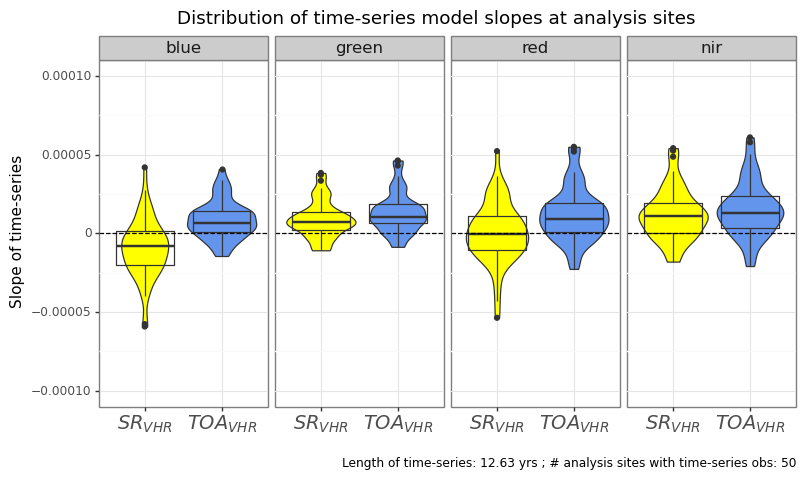

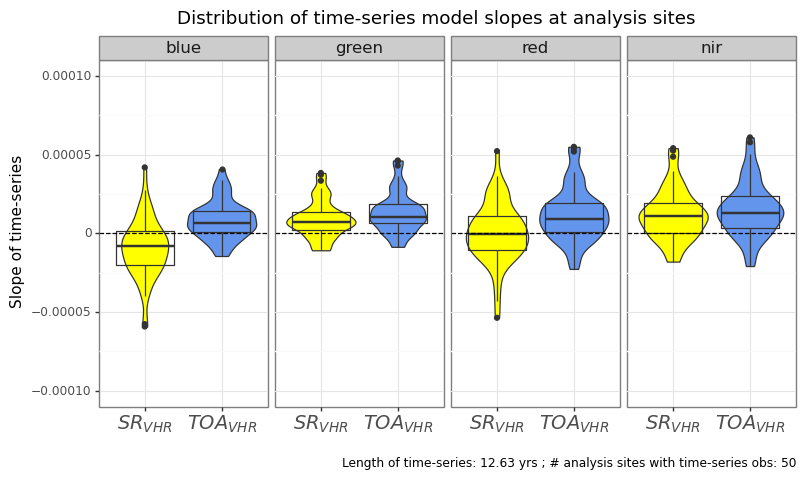

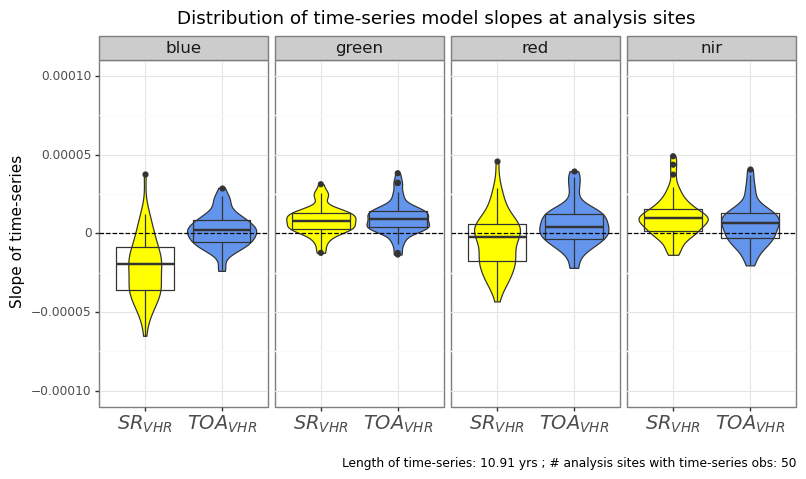

In [80]:
for i, df in enumerate(df_list):

    num_days_timeseries = (df['date'].max() - df['date'].min()).days
    num_yrs_timeseries = round(num_days_timeseries / 365.25, 2)

    df.date = pd.to_datetime(df.date)
    df['date_ordinal'] = pd.to_datetime(df['date']).map(dt.datetime.toordinal)
    df['site_str'] = df['site'].apply(str)

    smry_list = []
    # OLS model for reflectance value band x type_ref x site across 'date_ordinal' (independent var)
    for BAND in ['BAND_B','BAND_G','BAND_R','BAND_N']:
        if False:
            smry = df.groupby(['type_ref','site_str']).apply(OLSregress, BAND, ['date_ordinal'])
        else:
            smry_c = df.groupby(['type_ref','site_str']).apply(OLSregress_coefs, BAND, ['date_ordinal']).rename(columns={'date_ordinal': 'slope', 'intercept': 'intercept'}).reset_index()
            smry_p = df.groupby(['type_ref','site_str']).apply(OLSregress_pvals, BAND, ['date_ordinal']).rename(columns={'date_ordinal': 'slope_pval', 'intercept': 'intercept_pval'}).reset_index()
            smry = pd.concat([smry_c, smry_p[['slope_pval','intercept_pval']]], axis=1)

        smry['band'] = BAND
        smry_list.append(smry)

    smry_df = pd.concat(smry_list).reset_index()
    #smry_df = pd.MultiIndex.from_arrays(smry_list).to_frame()

    # re-order categories
    smry_df['band'] = smry_df['band'].astype('category').cat.rename_categories(BAND_RENAME_DICT_forPLOT).cat.reorder_categories(['blue', 'green','red','nir'])
    #smry_df['type_ref'] = smry_df['type_ref'].astype('category').cat.reorder_categories(['surface (VHR)', TOA_str, 'surface (reference)'])
    
    NAME = df_name_list[i]
    SHORTNAME = df_shortname_list[i]
    
    out_smrydf_fn = os.path.join(OUTDIR, 'data', f"data_smry{SEASONALITY}_{SHORTNAME}_n{len(df):05}_{SITE_ID_STRING}.csv")
    smry_df.to_csv(out_smrydf_fn)
    #smry_df_list.append(smry_df)
    
    num_sites_with_timeseries = len(smry_df[ (smry_df.type_ref == TOA_str) & (smry_df.band == 'nir')])
    
    if not SHOW_REFERENCE:
        smry_df = smry_df[smry_df.type_ref != SR_ref_str]
    print(f'Slope of time-series model across {num_yrs_timeseries} years\n({NAME})')
    p_obj_violins = (
        ggplot(data = smry_df) 
             #+ geom_point(aes(y='date_ordinal', x='type_ref', color='type_ref'))
             + geom_violin(aes(y='slope', x='type_ref', fill='type_ref'))
             + geom_boxplot(aes(y='slope', x='type_ref'), fill=None)
             + facet_grid('. ~ band')
             + geom_hline(aes(yintercept = 0), linetype='--')
             + coord_cartesian(ylim = [-10e-5, 10e-5])
             + scale_fill_manual(values=['yellow','cornflowerblue','gray'], name=' ')
             + labs(y = 'Slope of time-series', x=None, 
                    #title = f'Distribution of time-series model slopes at analysis sites across {num_yrs_timeseries} years\n({NAME})', 
                    title = f'Distribution of time-series model slopes at analysis sites', 
                    caption=f'Length of time-series: {num_yrs_timeseries} yrs ; # analysis sites with time-series obs: {num_sites_with_timeseries}')
             + theme_bw()
             #+ theme(axis_text_x=element_blank())
             + theme(strip_text=element_text(size=12), 
                     legend_position='none',
                     axis_text_x = element_text(size=14),
                    figure_size = (9, 4.5))
    )
    fig, p = p_obj_violins.draw(show=False, return_ggplot=True)
    if True:
        fig.savefig(os.path.join(OUTDIR, 'plots', f"figure_plot_distribs{SEASONALITY}_{SITE_ID_STRING}_{SHORTNAME}.tif"), dpi=300)